# Temporal Convolutional Networks (TCNs)

While Convolutional Neural Networks (CNNs) are typically associated with images, TCNs take that powerful architecture and tweak it for sequence modeling tasks — like predicting stock prices or classifying time series data.

TCNs offer a compelling alternative to traditional Recurrent Neural Networks (RNNs), including their more sophisticated counterparts, LSTMs and GRUs. Why? Because sequence data, especially when you're handling large datasets, demands both temporal consistency (causality) and flexibility in sequence length. With RNNs, you often deal with complex training times and gradient problems that can make your models unstable. TCNs? They sidestep a lot of these challenges.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

TCNs bring several advantages to the table. First, they support **parallelization**. Unlike RNNs, which process sequences one step at a time, TCNs can handle entire sequences in parallel. This not only speeds up the computation but also allows for more efficient use of your hardware resources.

Second, TCNs provide **stable gradient propagation**. Anyone who has tried to train deep RNNs knows the pain of vanishing or exploding gradients. TCNs, with their non-recursive architecture, handle this much better, giving you smoother and more stable training dynamics, even with long sequences.

Finally, TCNs have **longer effective memory**. They can easily manage long-range dependencies without suffering from memory degradation, something RNNs often struggle with as they try to hold onto information across many time steps.

In [3]:
class CausalConvBlock(nn.Module):
    """
    Implements one TCN layer.
    """

    def __init__(self, in_chs, out_chs, kernel, dilation, dropout=0.1) -> None:
        super(CausalConvBlock, self).__init__()
        pad= (kernel - 1) * dilation
        self.c_conv1d= nn.Conv1d(in_chs, out_chs, kernel, padding=pad, dilation=dilation)
        self.b_norm= nn.BatchNorm1d(out_chs)
        self.activ= nn.ReLU(inplace=True)
        self.dropout= nn.Dropout(p=dropout)


    def forward(self, x):
        # shape x[batch, filter/channel, timestep/length]
        x= self.c_conv1d(x)
        # remove trailing padding
        x= x[:, :, :-self.c_conv1d.padding[0]].contiguous()
        x= self.b_norm(x)
        x= self.activ(x)
        x= self.dropout(x)

        return x


**Core Architecture of Temporal Convolutional Networks:**

- TCNs use **1D convolutions** that slide over your input sequence. This is what makes them perfect for time-series data — they treat the temporal dimension as a continuous stream, applying convolutions to detect patterns and trends just like a CNN identifies edges or shapes in an image.

- **Causal convolutions** ensure that when the model is predicting the output at time $t$, it only looks at data from time t or earlier. This is what keeps the model grounded in the temporal sequence.

- TCNs use **dilated convolutions** to increase their receptive field without increasing the number of parameters drastically. Dilated convolutions allow the model to "see" farther into the sequence, capturing long-range dependencies by increasing the dilation rate at each layer. This technique ensures that even though the convolution kernel is small, it can cover large parts of the sequence without losing resolution or computational efficiency.

- **Depth and Receptive Field Expansion.** The deeper the network, the broader the receptive field — meaning, the model can see further back into the sequence. TCNs leverage this depth to capture both short-term patterns and long-term dependencies. As the depth increases, TCNs extend their memory horizon, allowing them to model intricate relationships across long sequences.

While TCNs don't suffer from vanishing gradients as much as RNNs, they can still benefit greatly from Batch Normalization. Normalizing the activations after each layer helps stabilize the training process, speeding up convergence and improving model generalization. Additionally, dropout is a must for regularization, especially if you're working with smaller datasets where overfitting can be a concern.

In [4]:
class Backbone(nn.Module):
    """
    Defining the TCN backbone.
    hiddens: list of hidden channels for each layer.
    dilations: list of dilation rates for each layer.
    """

    def __init__(self, n_blocks, in_chs, hidden_chs, kernel, dilation, dropout=0.1) -> None:
        super(Backbone, self).__init__()
        # dilated convolution
        self.temp_block1= CausalConvBlock(in_chs, hidden_chs[0], kernel, dilation[0], dropout)
        self.temp_blocks= nn.ModuleList([
            CausalConvBlock(hidden_chs[i], hidden_chs[i+1], kernel, dilation[i+1], dropout)
            for i in range(n_blocks-1)
        ])
        # 1x1 convolution for residual connection
        self.identity_conv= None
        if in_chs > 1 and in_chs != hidden_chs[-1]:
            self.identity_conv= nn.Conv1d(in_chs, hidden_chs[-1], kernel_size=1)
        self.activ= nn.ReLU()

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.kaiming_normal_(p)


    def forward(self, x):
        # dilated convolutions
        t= self.temp_block1(x)
        for block in self.temp_blocks:
            t= block(t)
        # residual connection
        if self.identity_conv is not None:
            x= self.identity_conv(x)

        return self.activ(x + t)


**Vanishing gradient:** This is where **residual connections** step in. These connections allow the model to learn identity mappings, ensuring that the gradient doesn't vanish as it flows backward through the network. They make deep networks not only trainable but also more accurate. In TCNs, residual connections are vital to maintaining stable gradient flow, especially in deep architectures designed to capture long-range dependencies.

In [5]:
class Head(nn.Module):
    """
    Implementing one MLP projection head (for data classification).
    """

    def __init__(self, in_dim, inner_dim, out_dim=1, dropout=0.1) -> None:
        super(Head, self).__init__()
        self.fc1= nn.Linear(in_dim, inner_dim)
        self.activ= nn.ReLU(inplace=True)
        self.dropout= nn.Dropout(p=dropout)
        self.fc2= nn.Linear(inner_dim, out_dim)

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.xavier_normal_(p)

    def forward(self, x):
        x= self.fc1(x)
        x= self.activ(x)
        x= self.dropout(x)
        x= self.fc2(x)

        return x


How do TCNs avoid the notorious gradient issues that plague RNNs? The answer lies in their non-recursive structure. Traditional RNNs rely on recursive computations, which makes them prone to gradient problems, especially when training deep networks. TCNs, on the other hand, don't suffer from this since their architecture is built on convolutions rather than recurrences. This not only results in stable gradient flow but also ensures that you don't need any specialized tricks (like gradient clipping) just to get the network to train properly. It's a much smoother ride.

# Building the Model

In [6]:
class TCN_Model(nn.Module):
    """
    Defining the full TCN model.
    """

    def __init__(self, config) -> None:
        super(TCN_Model, self).__init__()
        self.backbone= Backbone(
            config.n_blocks, config.input_chs, config.hidden_chs, config.kernel,
            config.dilation, config.dropout
        )
        self.head= Head(
            config.in_dim, config.inner_dim, config.out_dim, config.dropout
        )


    def forward(self, x):
        # shape x[batch, filter/channel, timestep/length]
        x= self.backbone(x)
        x= torch.flatten(x, 1)
        x= self.head(x)

        return x


RNNs process sequences step by step, in a sequential manner. That's essentially how LSTMs and GRUs work: they handle one time step at a time, making them inherently slow for long sequences.

TCNs are different. Thanks to their convolutional structure, they can process entire sequences in parallel. Instead of reading the book one page at a time, it's like having the ability to skim through all the chapters simultaneously, finding patterns across time steps faster and more efficiently. This parallelism is particularly useful when you're dealing with high-dimensional input data or large-scale datasets, making your training faster and more scalable.

# Creating a TCN

One of the keys to success with TCNs is the kernel size. A kernel size of 3 or 5 works well, as it captures local dependencies without overwhelming the model. Meanwhile, the dilation factors (usually powers of 2 like 1, 2, 4, 8) allow the TCN to expand its receptive field exponentially, enabling it to learn both short-term and long-term dependencies.

In [7]:
@dataclass
class TCNConfig:
    # --- backbone ---
    n_blocks= 3
    input_chs= 1
    hidden_chs= [64,64,64]
    kernel= 3
    dilation= [1,2,4]
    # --- head ---
    in_dim= 320
    inner_dim= 64
    out_dim= 1
    dropout= 0.1


model= TCN_Model(TCNConfig()).to(device)

total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

print(model)

Number of parameters: 45953
TCN_Model(
  (backbone): Backbone(
    (temp_block1): CausalConvBlock(
      (c_conv1d): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (b_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (temp_blocks): ModuleList(
      (0): CausalConvBlock(
        (c_conv1d): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (b_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): CausalConvBlock(
        (c_conv1d): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
        (b_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
        (dropout): Dropout(p=0.1, inpla

# Data Loading

In [16]:
from google.colab import drive
drive.mount('/content/drive/')
PATH= '/content/drive/My Drive/Colab Notebooks/data/Google_Stock_Train_2010_2022.csv'

Mounted at /content/drive/


- **Normalization/Scaling:** Data can have vastly different magnitudes depending on the time of year and other factors. You'll want to normalize or standardize the data so that all features are on a comparable scale. This helps the TCN learn efficiently without being biased by large values.

- **Windowing:** In time-series forecasting, it's essential to create sliding windows of data. For instance, if you're predicting the electricity load for the next 24 hours, you might take the last 7 days of data (or whatever makes sense based on historical patterns) as input. In practice, you'd create overlapping sequences of input-output pairs.

In [72]:
from sklearn.preprocessing import StandardScaler

class TimeSeriesData:
    """
    Dataset class for time series data.
    Parameters:
        device (str): device to use for training
        ticker (str): stock ticker symbol
        start_date (str): start date for data retrieval
        end_date (str): end date for data retrieval
        look_back (int): number of previous time steps to include in each sample
        train_size (float): proportion of data to use for training
    """

    def __init__(self, device, start_date, end_date, look_back=1, train_size=0.67) -> None:
        self.device= device
        self.start_date= start_date
        self.end_date= end_date
        self.look_back= look_back
        self.train_size= train_size


    def std_scaler(self, train, test):
        """
        Scaling with StandardScaler.
        Parameters:
            train (np.ndarray): training data
            test (np.ndarray): testing data
        """

        scaler= StandardScaler()

        scaled_train= scaler.fit_transform(train)
        scaled_test = scaler.transform(test)

        return scaled_train, scaled_test


    def load_data(self, path):
        """
        Load stock data.
        Returns:
            np.ndarray, training data
            np.ndarray, testing data
        """

        df= pd.read_csv(path)
        df= df[(df['Date']>= self.start_date) & (df['Date'] <= self.end_date)]
        df= df.set_index('Date')
        df= df.sort_index()
        df= df.loc[self.start_date:self.end_date]
        df= df[['Close']].astype(float) # use closing price
        df= df.values                   # convert DataFrame to np.array

        train_size= int(len(df) * self.train_size)
        train, test= self.std_scaler(df[0:train_size,:], df[train_size:len(df),:])

        return train, test


    def create_sliding_windows(self, data):
        """
        Create the dataset for time series prediction.
        Parameters:
            data (np.ndarray) input data
        Returns:
            np.ndarray, input data
            np.ndarray, output data
        """

        Xds, Yds= [], []
        for i in range(len(data)-self.look_back):
            feature= data[i : i +self.look_back]
            target = data[i +self.look_back : i +self.look_back +1]
            Xds.append(feature)
            Yds.append(target)

        return np.array(Xds), np.array(Yds)


    def split_train_test(self, path):
        """
        Get the training and testing data.
        Returns:
            torch.tensor, training input
            torch.tensor, training output
            torch.tensor, testing input
            torch.tensor, testing output
        """

        train, test= self.load_data(path)
        Xtr, Ytr= self.create_sliding_windows(train)
        Xte, Yte= self.create_sliding_windows(test)

        # reshape input to be [batch, filter/channel, timestep/length]
        Xtr= np.reshape(Xtr, (Xtr.shape[0], 1, Xtr.shape[1]))
        Xte= np.reshape(Xte, (Xte.shape[0], 1, Xte.shape[1]))

        Xtr= torch.tensor(Xtr, requires_grad=True).type(torch.float32).to(device)
        Ytr= torch.tensor(Ytr.squeeze(axis=-1)).type(torch.float32).to(device)
        Xte= torch.tensor(Xte, requires_grad=True).type(torch.float32).to(device)
        Yte= torch.tensor(Yte.squeeze(axis=-1)).type(torch.float32).to(device)

        return Xtr, Ytr, Xte, Yte


In [75]:
# instantiate the dataset
data= TimeSeriesData(device, '2010-1-1', '2020-12-31', look_back=5)
Xtr, Ytr, Xte, Yte= data.split_train_test(PATH)

# reshape input to be [batch, filter/channel, timestep/length]
print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([1724, 1, 5]), Ytr - torch.Size([1724, 1])
Shape of test data: Xte - torch.Size([847, 1, 5]), Yte - torch.Size([847, 1])


# Training

Speaking of stabilizing training, implementing early stopping is a smart move. This ensures you don't overfit on the training data. You stop the training when the validation loss stops improving after a set number of epochs (patience). This saves time and resources while preventing overfitting.

In [67]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    Args:
        patience (int): Number of epochs to wait before stopping the training.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        verbose (bool): If True, prints a message for each epoch where the loss does not improve.
    """

    def __init__(self, patience=7, cutoff=1e-9, verbose=False):
        self.patience= patience
        self.cutoff= cutoff
        self.verbose= verbose
        self.counter= 0
        self.last_loss= None
        self.early_stop= False


    def __call__(self, current_loss, epoch):
        """
        Args:
            val_loss (float): The validation loss to check if the model performance improved.
        Returns:
            bool: True if the loss did not improve, False if it improved.
        """
        if self.last_loss is None:
            self.last_loss= current_loss
        else:
            loss_change= np.abs(self.last_loss - current_loss)

            # deciding to stop if loss is not decreasing fast enough
            if loss_change< self.cutoff:
                self.counter += 1

                if self.counter> self.patience:
                    self.early_stop= True
                    if self.verbose:
                        print('\nEarly stopping at epoch {}'.format(epoch))
            else:
                self.counter= 0
            # setting current loss as previous loss
            self.last_loss= current_loss


In [68]:
def training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
             batch_size=64, patience=7, cutoff=1e-9, verbose=False):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.MSELoss()

    early_stopping= EarlyStopping(patience=patience, cutoff=cutoff, verbose=verbose)

    # tracking statistics
    train_hist= []
    test_hist= []

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []

        # iterating over all batches
        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[(i * batch_size) : ((i+1) * batch_size)]
            Ymb= Ytr[(i * batch_size) : ((i+1) * batch_size)]

            # --- forward pass and get loss ---
            model.train(True)
            y_pred= model(Xmb)
            loss_tr= loss_fn(y_pred.view(Ymb.shape), Ymb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                y_pred= model(Xte)
                loss_te= loss_fn(y_pred.view(Yte.shape), Yte)

            early_stopping(current_loss=loss_te.item(), epoch=epoch)
            if early_stopping.early_stop:
                test_hist.append(loss_te.item())
                model.train(False)
                break

        test_hist.append(loss_te.item())


    return train_hist, test_hist

In [83]:
# ----- reseting the 45k params TCN model -----
model= TCN_Model(TCNConfig()).to(device)

train_hist, test_hist= training(model, learning_rate=1e-3, epochs=500, eval_interval=5,
                                batch_size=256)

100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


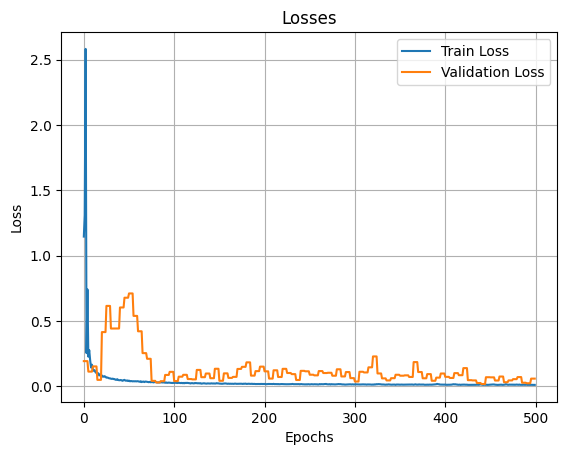

In [85]:
plt.plot(train_hist, label='Train Loss')
plt.plot(test_hist, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

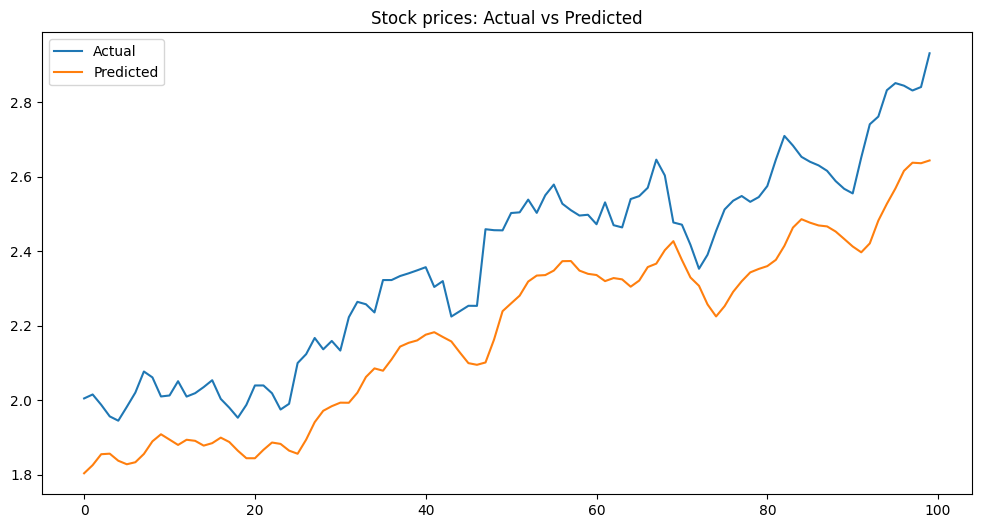

In [88]:
# Predictions
model.train(False)
with torch.no_grad():
    y_pred= model(Xte)

# Plot actual vs predicted load
plt.figure(figsize=(12, 6))
plt.plot(Yte[:100], label="Actual")
plt.plot(y_pred[:100], label="Predicted")
plt.title("Stock prices: Actual vs Predicted")
plt.legend()
plt.show()

Temporal Convolutional Networks (TCNs) offer a powerful, flexible, and scalable alternative to traditional RNN-based models for sequence modeling tasks. The ability to leverage parallelism, stable gradient propagation, and efficient memory retention gives TCNs a clear edge, especially in applications that involve long-range dependencies like time-series forecasting or action recognition.

While TCNs outperform RNNs in many scenarios, there are still cases where RNNs, especially attention-based models like Transformers, excel — particularly when dealing with irregular sequences or where attention mechanisms shine. However, if you need a highly parallelizable and memory-efficient model, TCNs are definitely the go-to choice.

In [ ]:
# https://medium.com/@amit25173/temporal-convolutional-network-an-overview-4d2b6f03d6f8
# https://github.com/morgengramlich/temporal_convolutional_network/blob/main/tcn/tcn.py
# https://www.kaggle.com/code/ceshine/pytorch-temporal-convolutional-networks